In [65]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
!cp /content/drive/MyDrive/hw2/ncc.py .
import ncc
import scipy

In [66]:
# PART 1. Question 2. (2 points)

def MakeGaussianPyramid(image, scale, minsize):
  '''
  Returns a gaussian pyramid as a list of numpy arrays
  Parameters:
  - image: PIL image
  - scale: factor to scale image from one line to next up the pyramid
  - minsize: minimum of the longest dimension of the image
  '''
  pyramid = []
  # get dimensions and mode (black/white = "L", RGB = "RGB")
  image_copy = image.copy()
  width, height = image_copy.size
  mode = image_copy.mode

  while max(width, height) >= minsize:
    # convert and push current image onto pyramid     
    image_array = (np.asarray(image_copy, dtype=np.float32)).copy()
    pyramid.append(image_array)
    # reassign width and height for next image, check if it's of proper size
    width = int(width * scale)
    height = int(height * scale)
    if max(width, height) >= minsize:
      filtered_array = np.zeros(image_array.shape)
      # check for specific mode, black and white or RGB, smooth with gaussian
      if mode == "L":
        filtered_array = scipy.ndimage.gaussian_filter(image_array, sigma=1/(2*scale))             
      else:
        for colour in range(0, 3):
          filtered_array[:,:,colour] = scipy.ndimage.gaussian_filter(image_array[:,:,colour], sigma=1/(2*scale))
      filtered_image = Image.fromarray(filtered_array.astype('uint8'), mode=mode)
      # down sample (resize)
      image_copy = filtered_image.resize((width, height), Image.BICUBIC)
  return pyramid

In [67]:
# Question 3. (3 points)
def ShowGaussianPyramid(pyramid):
  '''
  Joins all images in pyramid into array
  Parameter:
  - pyramid: the pyramid to be displayed, numpy arrays (h, w)
  '''
  # get dimensions of array (pyramid)
  width = 0
  for arr in pyramid:
    width += arr.shape[1]
  height = pyramid[0].shape[0]

  mode = "L"
  if pyramid[0].ndim == 3: # RGB
    mode = "RGB"
    result_image = Image.new(mode, (width, height), 255)
  else: # Black and White
    result_image = Image.new(mode, (width, height), 'white')
  
  # paste images from pyramid onto new single image
  offset_x = 0
  offset_y = 0
  for arr in pyramid:
    img = Image.fromarray(arr.astype('uint8'), mode=mode)
    result_image.paste(img, (offset_x, offset_y))
    offset_x += img.size[0]
    offset_y += int(img.size[1]/4)
  # save and display pyramid image
  result_image.save("show_gaussian_pyramid.png", "PNG")
  display(result_image)

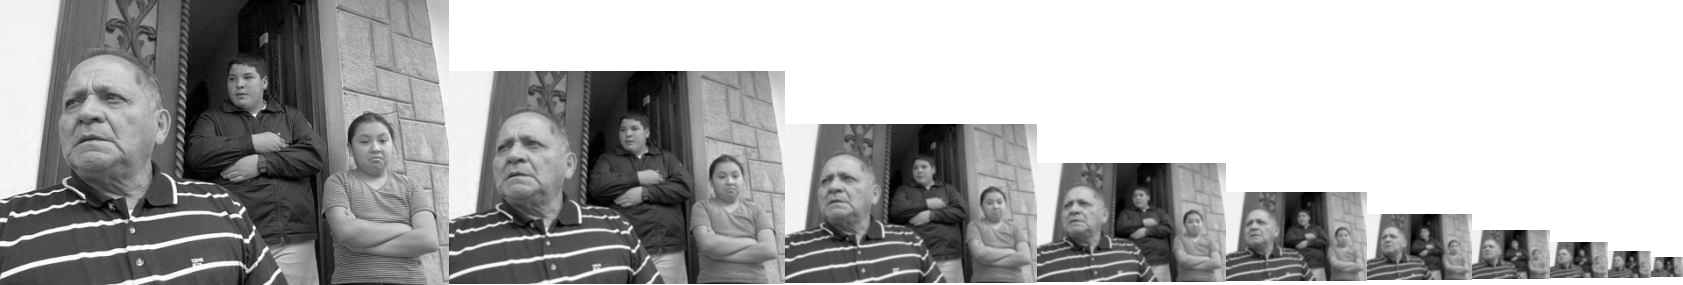

In [68]:
img = Image.open("/content/drive/MyDrive/hw2/faces/family.jpg")
pyramid = MakeGaussianPyramid(img, 0.75, 30)
ShowGaussianPyramid(pyramid)

Original Gaussian Pyramid


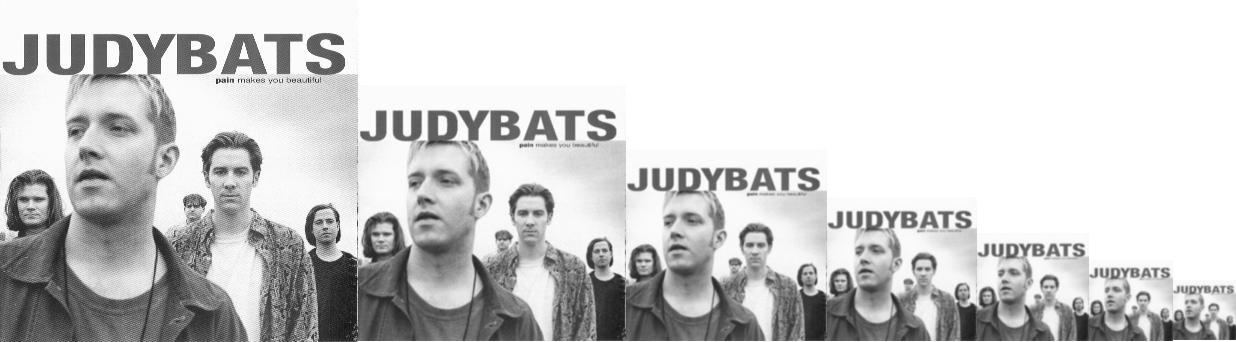

Marked Image from Gaussian pyramid


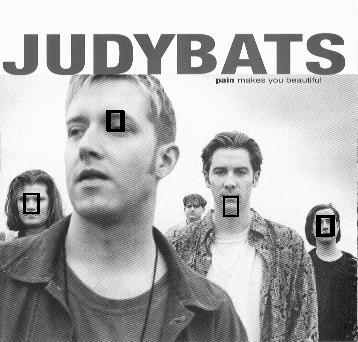

In [69]:
# Question 4. (10 points)

def FindCorners(image, template, position_center):
  '''
  Returns the four corner positions of the area where the threshold has been reached
  Parameters:
  - image: the PIL image 
  - template: template PIL image
  - position_center: the center position at which the template will be drawn around (x, y)

  corner1 ---------- corner2
    |                  |
    |                  |
    |                  |
    |                  |
    |                  |
    |                  |
    |                  |
    |                  |
  corner3 ---------- corner4

  '''
  image_width, image_height = image.size
  template_width, template_height = template.size

  # initialize corners
  corner1 = [0]*2
  corner2 = [0]*2
  corner3 = [0]*2
  corner4 = [0]*2

  half_width = template_width/2
  half_height = template_height/2

  # set corner x positions
  corner1[0] = position_center[0] - half_width
  corner3[0] = position_center[0] - half_width

  corner2[0] = position_center[0] + half_width
  corner4[0] = position_center[0] + half_width

  # set corner y positions - odd height
  corner1[1] = position_center[1] - half_height
  corner3[1] = position_center[1] + half_height

  corner2[1] = position_center[1] - half_height
  corner4[1] = position_center[1] + half_height

  return corner1, corner2, corner3, corner4


def FindTemplate(pyramid, template, threshold):
  '''
  Find and mark all locations in the pyramid where NCC of the template
  and image reach the threshold
  Paramters:                
  - pyramid: image pyramid of (height, width) numpy arrays
  - template: template as (height, width) numpy array
  - threshold: float value considered to match template to part of pyramid image
  '''

  # create blank slate for new image as numpy array
  result_image = Image.fromarray(pyramid[0].astype('uint8'))
  image_array = np.asarray(result_image, dtype=np.float32)
  width = image_array.shape[1]
  height = image_array.shape[0]

  # search every image in pyramid
  for img in pyramid:
    # NCC (Normalized Cross-Correlation), array of cross-correlation coefficients [-1.0, 1.0]
    PIL_image = Image.fromarray(img.astype('uint8'))
    PIL_template = Image.fromarray(template.astype('uint8'))
    ncc_array = ncc.normxcorr2D(PIL_image, PIL_template)

    # find where threshold has been reached, fills array with Boolean values from condition
    ncc_array_above_threshold = ncc_array > threshold

    # mark image around threshold area
    image_width, image_height = PIL_image.size
    template_width, template_height = PIL_template.size

    marked_image_array = np.zeros((PIL_image.size[1], PIL_image.size[0]))
    marked_image = Image.fromarray(marked_image_array.astype('uint8'))
    # convert to RGB to draw coloured lines
    marked_image.convert("RGB")
    draw = ImageDraw.Draw(marked_image)
    for row in range(0, image_height):
      for col in range(0, image_width):
        # True represents a threshold area
        if ncc_array_above_threshold[row, col]:
          # get corner pixels 
          corner1, corner2, corner3, corner4 = FindCorners(PIL_image, PIL_template, (col, row))
          # draw lines vertically and horiozntally between corners to draw rectangle
          draw.line((corner1[0], corner1[1], corner2[0], corner2[1]), fill="white", width=2)
          draw.line((corner1[0], corner1[1], corner3[0], corner3[1]), fill="white", width=2)
          draw.line((corner4[0], corner4[1], corner2[0], corner2[1]), fill="white", width=2)
          draw.line((corner4[0], corner4[1], corner3[0], corner3[1]), fill="white", width=2)
    del draw
    # overlay marked pixels onto original image and -
    # -resize marked image to image_array's size
    marked_image.resize((width, height))

    for row in range(0, height):
      for col in range(0, width):
        # if the marked image pixel is anything but black, make that pixel black on the original image
        if marked_image.getpixel((col, row)) != 0:
          image_array[row, col] = 0
    return image_array


pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/judybats.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)

# template
template_width = 15 # 23 works best but for the sake of the assignment
template = Image.open("/content/drive/MyDrive/hw2/faces/template.jpg")
template_aspect_ratio = float(template_width)/template.size[0]
template_height = template.size[1]
template_resize = template.resize((template_width, int(template_aspect_ratio*template_height)), Image.BICUBIC)
template_array = np.asarray(template_resize, dtype=np.float32)

# find template within pyramid
threshold = 0.5
marked_array = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array.astype('uint8'))
marked_image.save("template_matching_q4.png", "PNG")

print("Original Gaussian Pyramid")
ShowGaussianPyramid(pyramid)
print("Marked Image from Gaussian pyramid")
display(marked_image)

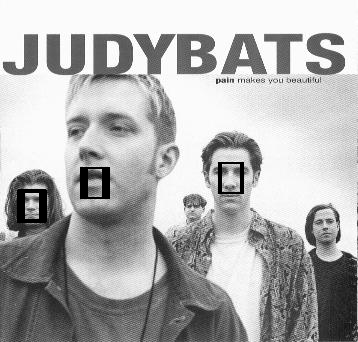

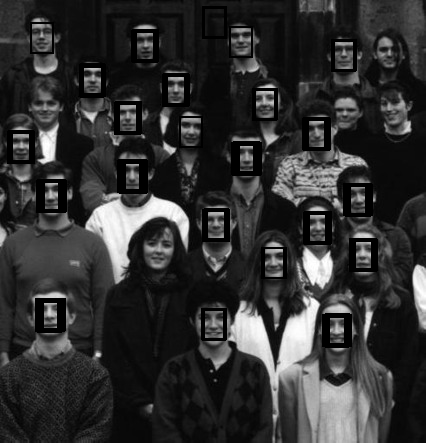

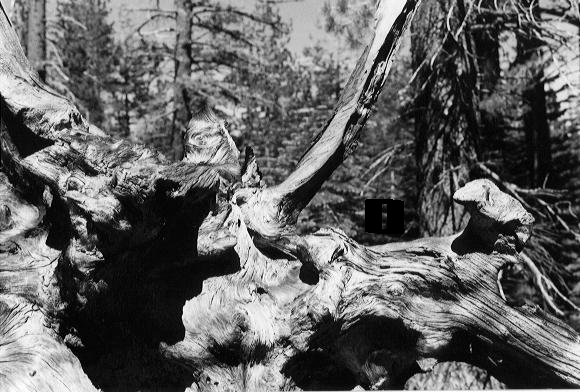

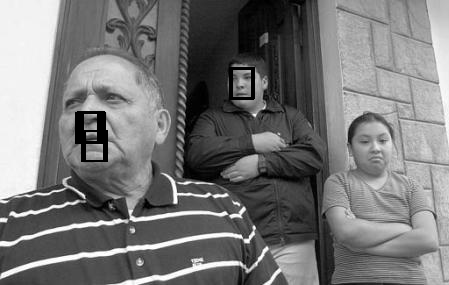

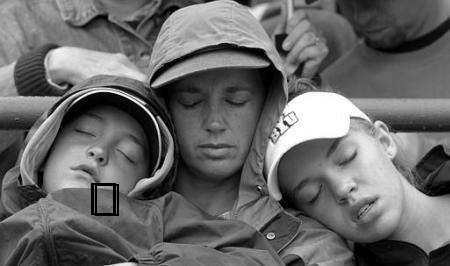

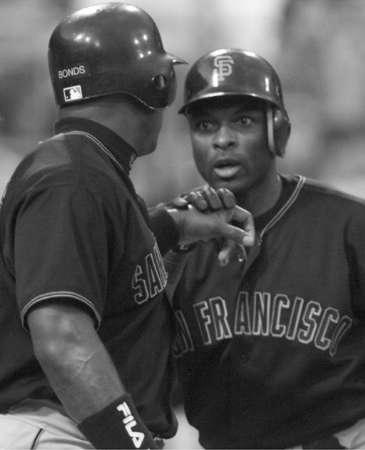

In [70]:
# Question 5. (5 points)

# template
template_width = 23 # 23 works best but for the sake of the assignment
template = Image.open("/content/drive/MyDrive/hw2/faces/template.jpg")
template_aspect_ratio = float(template_width)/template.size[0]
template_resize = template.resize((template_width, int(template_aspect_ratio*template.size[1])), Image.BICUBIC)
template_array = np.asarray(template_resize, dtype=np.float32)

threshold = 0.5


# judy bats
pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/judybats.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)
marked_array_judy_bats = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array_judy_bats.astype('uint8'))
marked_image.save("judy_bats_q5.png", "PNG")
display(marked_image)

# students
pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/students.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)
marked_array_students = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array_students.astype('uint8'))
marked_image.save("students_q5.png", "PNG")
display(marked_image)

# tree
pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/tree.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)
marked_array_tree = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array_tree.astype('uint8'))
marked_image.save("tree_q5.png", "PNG")
display(marked_image)

# family
pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/family.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)
marked_array_family = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array_family.astype('uint8'))
marked_image.save("family_q5.png", "PNG")
display(marked_image)

# fans
pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/fans.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)
marked_array_fans = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array_fans.astype('uint8'))
marked_image.save("fans_q5.png", "PNG")
display(marked_image)

# sports
pyramid_img = Image.open("/content/drive/MyDrive/hw2/faces/sports.jpg")
pyramid = MakeGaussianPyramid(pyramid_img, 0.75, 60)
marked_array_sports = FindTemplate(pyramid, template_array, threshold)
marked_image = Image.fromarray(marked_array_sports.astype('uint8'))
marked_image.save("sports_q5.png", "PNG")
display(marked_image)



False positives, False negatives

Judybats: 0, 2

Students: 1, 5

Tree: 1, 0

Family: 0, 1

Fans: 2, 3

Sports: 0, 0

In [71]:
def recall(true_positives, false_negatives):
  '''
  Returns the recall rate
  Parameters:
  - true_positives: faces successfully marked
  - false_negatives: faces not marked
  '''
  total = true_positives + false_negatives
  if (total) != 0:
    return str(true_positives/total) # formula for recall found at: https://en.wikipedia.org/wiki/Precision_and_recall
  else: # "a perfect recall score of 1.0 means that all relevant documents were retrieved by the search"
    return str(1)

  
print("judybats recall rate: " + recall(3, 2))
print("students recall rate: " + recall(22, 5))
print("tree recall rate: " + recall(0, 1))
print("tree recall rate: " + recall(2, 1))
print("family recall rate: " + recall(0, 3))
print("sports recall rate: " + recall(0, 1))

judybats recall rate: 0.6
students recall rate: 0.8148148148148148
tree recall rate: 0.0
tree recall rate: 0.6666666666666666
family recall rate: 0.0
sports recall rate: 0.0


The NCC method had a very low recall rate on some images, in particular, the sports and fans images. In these images, no true positives were marked. The reasons for these results may be due to factors such as:

- Skin color the sports image. The template given has much lighter skin tone.
- Hat in the both sports and fans images. This may cast shadows onto the faces and confuse the ncc process.
- Angled faces in the fans image. Our template isn't being rotated in the ncc process and therefore is expected to find faces that are parallel to the template.
- Eyes closed in fans image. The template face has eyes open. Eyes are a very distinct indicator of a face (due to the contrast between rest of face/distance between them/position on face).

In [72]:
# Part 2. Question 2. (3 points)

def MakeLaplacianPyramid(image, scale, minsize):
  '''
  Return a Laplacian Pyramid with given image 3D numpy array.
  Parameters:
  - image: PIL image to turn into pyramid
  - scale: scale to reduce image each level
  - minsize: minimum of the larger dimension of pyramid
  '''
  # To make a Laplacian pyramid we subtract the 
  l_pyramid = []
  g_pyramid = MakeGaussianPyramid(image, scale, minsize)
  length_g_pyramid = len(g_pyramid)
  if length_g_pyramid > 1: # has more than one level because we don't change the last image
    for index in range(0, length_g_pyramid-1):
      # get the current gaussian pyramid image
      curr_g_array = g_pyramid[index]
      filtered_array = np.zeros(curr_g_array.shape)
      # iterate through RGB values of the current gaussian array image (in 3D numpy array form)
      for colour in range(0, 3):
        filtered_array[:,:,colour] = scipy.ndimage.gaussian_filter(curr_g_array[:,:,colour], 1/(2*scale))
      # get residual by subtracting filtered by gaussian (Guassian - Filtered = Laplacian)
      laplacian_arr = curr_g_array - filtered_array
      l_pyramid.append(laplacian_arr)
      # add the last array in the gaussian pyramid to the laplacian pyramid
    l_pyramid.append(g_pyramid[-1])
  else: # has zero or one level
    l_pyramid = g_pyramid
  return l_pyramid

Orchid Lapalacian pyramid


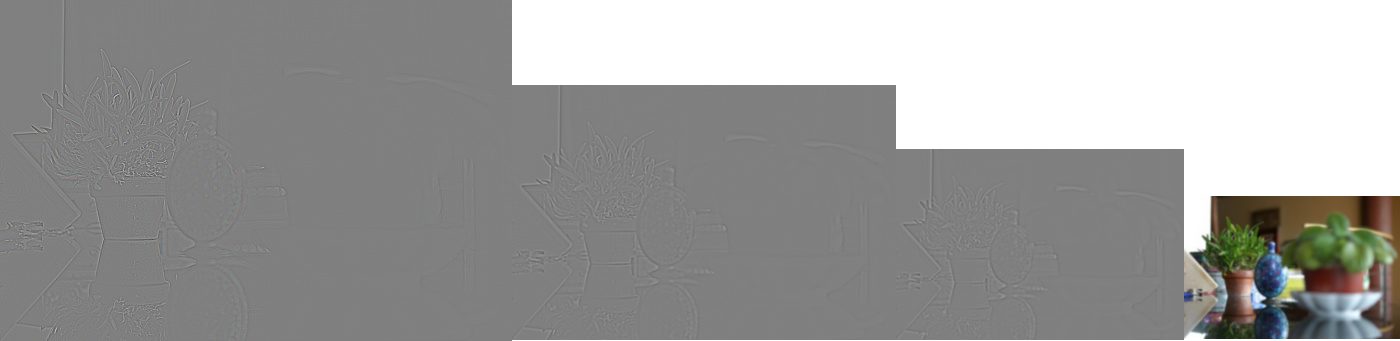

Violet Lapalacian pyramid


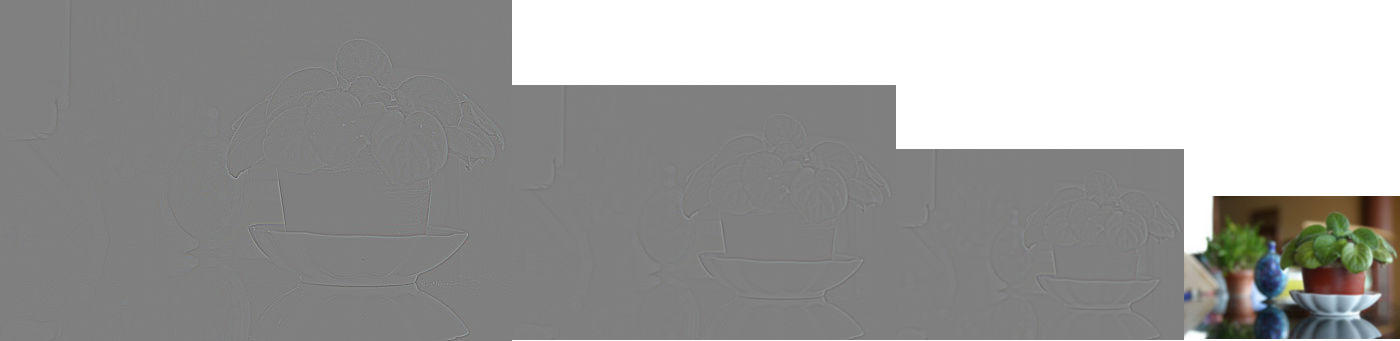

In [73]:
# Question 3. (2 points)

def ShowLaplacianPyramid(pyramid):
  '''
  Joins and displays the images in the pyramid in one image.
  Paramter:
  - pyramid: Laplacian pyramid made of 3D numpy array
  '''
  # get dimensions of array (pyramid)
  width = 0
  for i in pyramid:
    width += i.shape[1]
  height = pyramid[0].shape[0]

  result_image = Image.new("RGB", (width, height), color="white")
  
  # paste images from pyramid onto new single image
  offset_x = offset_y = 0
  length = len(pyramid)
  # iterate through all images in pyramid
  for arr in range(0, length):
    # get the current array
    curr_arr = pyramid[arr]
    # for all but the last level, add 128
    if arr != length-1:
      curr_arr = np.clip((curr_arr + 128), a_min=0, a_max=255)
    curr_image = Image.fromarray(curr_arr.astype('uint8'))
    result_image.paste(curr_image, (int(offset_x), int(offset_y)))
    offset_x += curr_image.size[0]
    offset_y += curr_image.size[1]/4
    
  result_image.save('l_pyramid_q3.png', 'PNG')
  display(result_image)

print("Orchid Lapalacian pyramid")
orchid = Image.open('/content/drive/MyDrive/hw2/hw2part2/orchid.jpg')
orchid_pyramid = MakeLaplacianPyramid(orchid, 0.75, 200)
ShowLaplacianPyramid(orchid_pyramid)

print("Violet Lapalacian pyramid")
violet = Image.open('/content/drive/MyDrive/hw2/hw2part2/violet.jpg')
violet_pyramid = MakeLaplacianPyramid(violet, 0.75, 200)
ShowLaplacianPyramid(violet_pyramid)

Orchid Gaussian pyramid reconstructed from Laplacian pyramid


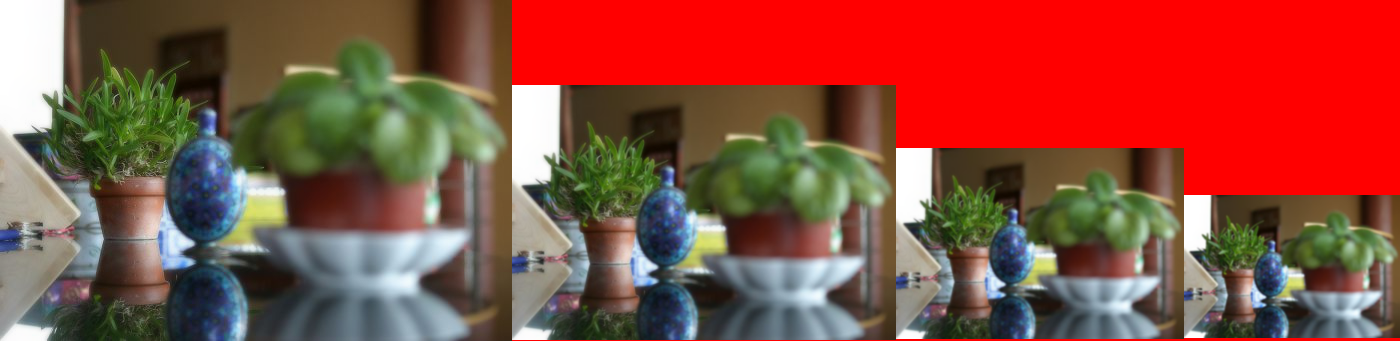

Orchid Gaussian pyramid


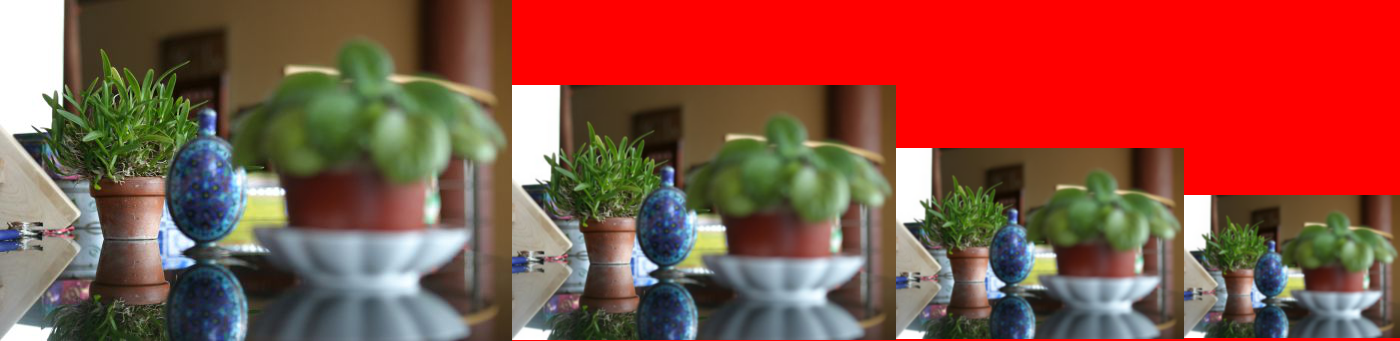

In [74]:
# Question 4. (5 points)
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  '''
  Reconstruct Gaussian pyramid from Laplacian Pyramid. To do this, we need to go
  backwards from MakeGaussian(), adding the interpolated Gaussian images to their
  corresponding Laplacian images.
  Parameters:
  - lPyramid: Laplacian Pyramid given as a list of 3D numpy arrays
  '''
  # initialize reconstructed Gaussian array
  gaussian_result = []
  # get the ratio to scale the image as we upsample 
  scale_ratio = lPyramid[1].shape[0]/lPyramid[0].shape[0]

  # append the last image in the array (smallest image)
  gaussian_result.append(lPyramid[-1])
  # reconstruct / append all other levels (starting from second last [-2] level onto gaussian_result
  # we use len(lPyramid)-2 because we've already appended the -1th array to our result, then use -1, -1 to
  # access all images in the 3D array
  for level in range(len(lPyramid)-2, -1, -1):
    # get the current image from laplacian pyramid (np array form)
    curr_laplacian_arr = lPyramid[level]
    curr_laplacian_arr_width = curr_laplacian_arr.shape[1]
    curr_laplacian_arr_height = curr_laplacian_arr.shape[0]
    # upsample and blurr level
    first_img = Image.fromarray(gaussian_result[0].astype('uint8'))
    upsample_first_img = first_img.resize((curr_laplacian_arr_width, curr_laplacian_arr_height), Image.BICUBIC)
    upsample_first_img_arr = np.asarray(upsample_first_img, dtype=np.float32)
    blurred_arr = np.zeros(upsample_first_img_arr.shape)
    
    # iterate through all colour channels (R=0, G=1, B=2)
    for colour in range(0, 3):
      blurred_arr[:,:,colour] = scipy.ndimage.gaussian_filter(upsample_first_img_arr[:,:,colour], 1/(2*scale_ratio))
    # add blurred image to the residual above
    curr_plus_blurred = curr_laplacian_arr + blurred_arr

    # push curr_plus_blurred to front of gaussian pyramid
    gaussian_result.insert(0, curr_plus_blurred)

  return gaussian_result

print("Orchid Gaussian pyramid reconstructed from Laplacian pyramid")
orchid = Image.open('/content/drive/MyDrive/hw2/hw2part2/orchid.jpg')
orchid_laplacian_pyramid = MakeLaplacianPyramid(orchid, 0.75, 200)
reconstructed_orchid = ReconstructGaussianFromLaplacianPyramid(orchid_laplacian_pyramid)
ShowGaussianPyramid(reconstructed_orchid)

print("Orchid Gaussian pyramid")
orchid_gaussian_pyramid = MakeGaussianPyramid(orchid, 0.75, 200)
ShowGaussianPyramid(orchid_gaussian_pyramid)


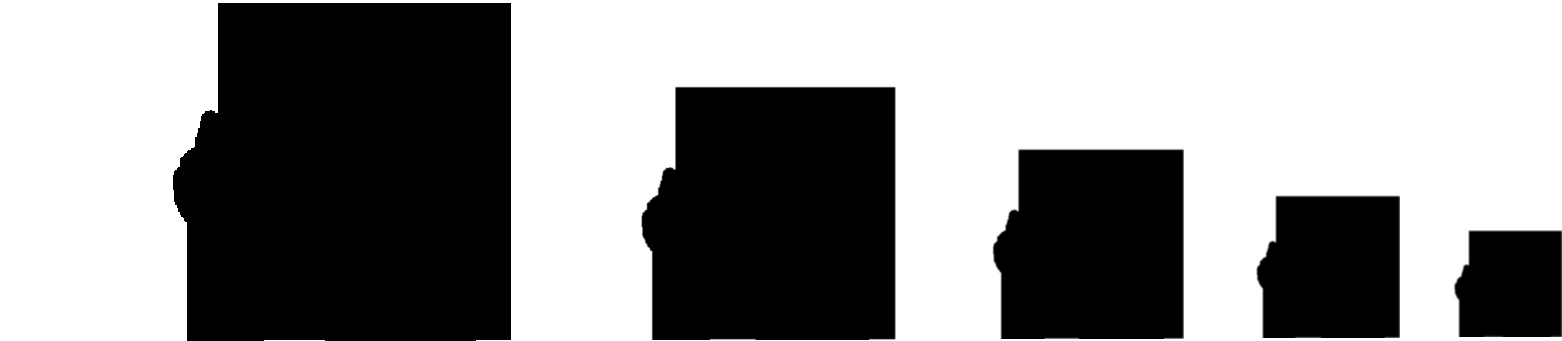

In [75]:
img = Image.open("/content/drive/MyDrive/hw2/hw2part2/orchid_mask.bmp")
pyramid = MakeGaussianPyramid(img, 0.75, 150)
ShowGaussianPyramid(pyramid)

In [76]:
# Question 6. (5 points)
def UpsampleBlur(img_arr, width, height):
  '''
  Returns the result of upsampling and blurring the img_arr
  Parameter:
  - img_arr: the array of the PIL image to be upsampled and blurred
  - width: width to resize the image to 
  - height: height to resize the image to 
  '''
  # convert img_arr to Image
  img = Image.fromarray(img_arr.astype('uint8'))
  # resize the Image
  upsample = img.resize((width, height), Image.BICUBIC)
  # convert BACK to array
  upsample_arr = np.asarray(upsample, dtype=np.float32)
  # cap the values at 0 to 255 for viewing
  clipped_arr = np.clip(upsample_arr, 0, 255)
  return clipped_arr

def Blend(file1, file2, mask, scale, minsize):
  '''
  Returns a blend of file1 and file2 using mask
  Parameter:
  - file1: string path to first PIL image
  - file2: string path to second PIL image
  - mask: string path to mask PIL image
  - scale: amount to resize the pyramids
  - minsize: minimum of the larger dimension of pyramid
  '''
  img_1 = Image.open(file1)
  img_2 = Image.open(file2)
  img_mask = Image.open(mask)

  img_1_l_pyramid = MakeLaplacianPyramid(img_1, scale, minsize)
  img_2_l_pyramid = MakeLaplacianPyramid(img_2, scale, minsize)
  img_mask_g_pyramid = MakeGaussianPyramid(img_mask, scale, minsize)

  # get the gaussian pyramids from img_1 and img_2
  gaussian_pyramid_img_1 = MakeGaussianPyramid(img_1, scale, minsize)
  gaussian_pyramid_img_2 = MakeGaussianPyramid(img_2, scale, minsize)

  # convert 2D array to 3D array for computations with Laplacian pyramid
  gaussian_pyramid_mask = []
  for i in img_mask_g_pyramid:
    i = np.repeat(i[:,:,None], 3, axis=2)
    gaussian_pyramid_mask.append(i)


  # combine laplacian pyramids
  combined_laplacian = []
  for index in range(0, len(img_1_l_pyramid)-1):
    # Equation given in assignment spec: compLaplacian[i] = lapA[i] * gaussianM[i]/255 +  lapB[i] * (1 - gaussianM[i]/255)
    combined_laplacian.append(img_1_l_pyramid[index] * gaussian_pyramid_mask[index]/255 + img_2_l_pyramid[index] * (1 - gaussian_pyramid_mask[index]/255))

  result_arr = []
  # iterate through all levels of combined laplacian array
  for level in range(len(combined_laplacian)-1, -1, -1):
    # if it's not the last level, upsample and blur
    if level != len(combined_laplacian)-1:
      result_arr = UpsampleBlur(result_arr, combined_laplacian[level].shape[1], combined_laplacian[level].shape[0], 1/(2*scale)) + combined_laplacian[level]
    # else upsample, blur, and sum with the residual to get the blended image from both img_1, img_2
    else:
      img_1_last_arr = gaussian_pyramid_img_1[-1]
      img_2_last_arr = gaussian_pyramid_img_2[-1]
      img_1_blurred_arr = UpsampleBlur(img_1_last_arr, combined_laplacian[level].shape[1], combined_laplacian[-1].shape[0])
      img_2_blurred_arr = UpsampleBlur(img_2_last_arr, combined_laplacian[level].shape[1], combined_laplacian[-1].shape[0])
      # combined upsampled + blurred images with mask
      # Equation given in assignment spec: compLaplacian[i] = lapA[i] * gaussianM[i]/255 +  lapB[i] * (1 - gaussianM[i]/255)
      img_1_2_arr = img_1_blurred_arr * gaussian_pyramid_mask[level]/255 + img_2_blurred_arr * (1 - gaussian_pyramid_mask[level]/255)
      # sum with residual
      result_arr = combined_laplacian[level] + img_1_2_arr
          
    # cap the values between 0 and 255 for viewing, then convert array to PIL image
    result_img = Image.fromarray(np.clip(result_arr, 0, 255).astype('uint8'))
    return result_img

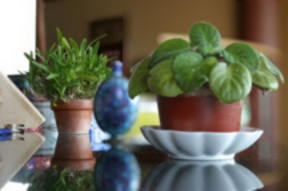

In [77]:
orchid_violet_blend = Blend('/content/drive/MyDrive/hw2/hw2part2/orchid.jpg', '/content/drive/MyDrive/hw2/hw2part2/violet.jpg', '/content/drive/MyDrive/hw2/hw2part2/orchid_mask.bmp', 0.75, 200)
orchid_violet_blend.save('blend_orchid_violet.png', 'PNG')
display(orchid_violet_blend)

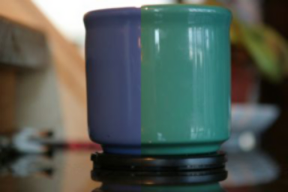

In [78]:
blue_green_blend = Blend('/content/drive/MyDrive/hw2/hw2part2/blue_cup.jpg', '/content/drive/MyDrive/hw2/hw2part2/green_cup.jpg', '/content/drive/MyDrive/hw2/hw2part2/cup_mask.bmp', 0.75, 200)
blue_green_blend.save('blend_blue_green.png', 'PNG')
display(blue_green_blend)


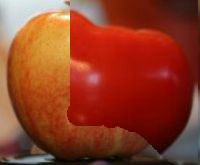

In [79]:
imageAppleTomato = Blend('/content/drive/MyDrive/hw2/hw2part2/apple.jpg', '/content/drive/MyDrive/hw2/hw2part2/tomato.jpg', '/content/drive/MyDrive/hw2/hw2part2/tomato_mask.bmp', 0.75, 150)
imageAppleTomato.save('blend_apple_tomato.png', 'PNG')
display(imageAppleTomato)